# When Do Neural Networks Outperform Kernel Methods?




==============================
<!-- GITHUB REPOSITORY -->
## Github repository
The up-to-date version of the code can be found at [this github link](https://github.com/OliverPotocki/neural-networks-and-linearizations).

<!-- ACKNOWLEDGMENTS -->
## Acknowledgments

The ideas behind this code are based on research done in the paper [B. Ghorbani, S. Mei,T. Misiakiewicz, A. Montanari., When Do Neural Networks Outperform Kernel Methods? *arXiv preprint*, 2021](https://arxiv.org/abs/2006.13409).

The MNIST-1D data set was created by [S. Greydanus, Scaling down Deep Learning
 *arXiv preprint*, 2020](https://arxiv.org/abs/2011.14439).

<!-- PROJECT -->
## Introduction

The goal is to investigate and compare the performance of neural networks and kernel methods in dependence on data determined by low dimensional projections.

Ghorbani et. al. conjecture, that kernel methods perform well, when a latent low-dimensional structure in the target function is aligned with a low-dimensional structure in the data.

In general a signal to noise ratio is of the form 

$$\frac{\textrm{power}(\textrm{signal})}{\textrm{power}(\textrm{noise})} \sim \frac{\textrm{mean}(\textrm{signal})}{\textrm{std}(\textrm{noise})}$$

Kernel methods are assumed to perform well, when the signal to noise ratio is high, but suffer from the curse of dimentionality when it is not. Neural networks on the contrary are conjectured to be learn a low dimensional representation of the data thus be less affected by a low signal to noise ratio.

We assume image data in a classification task to be of a similar structure, as the label depends predominantly on the low frequencies and images have the spectrum concentrated on their low frequency components.

The goal of this notebook is to investigate these conjectures by conducting experiments on two datasets, the MNIST data set and the MNIST-1D data set.

<!-- TABLE OF CONTENTS -->
## Structure of notebook
1. [Imports](#imports)
2. [Implementation](#randomstate)
3. [Plotting functions](#plotting)
4. [Data](#data)
5. [Models](#models)
6. [Noise data experiments](#noise)
7. [Synthetic data experiments](#synthetic)





## Imports <a name="imports"></a>

In [ ]:
# -----------------------------------------------------------
# When Do Neural Networks Outperform Kernel Methods?
#
# 2021 Oliver Potocki, Bonn, Germany
# email oliver.potocki@gmail.com
# -----------------------------------------------------------

In [ ]:
%%capture
!pip install neural_tangents
!pip install optax

In [ ]:
%matplotlib inline

import time
from functools import partial
from typing import Any, Callable, Dict, Iterable, List, Optional, Tuple, Union

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import neural_tangents as nt
import numpy as np
import optax
import pickle
import requests
import scipy as sc
import seaborn as sns
import torch as th
from jax import grad, jit, pmap, random, value_and_grad, vmap
from neural_tangents import stax
from scipy.fftpack import dct, idct
from sklearn.exceptions import ConvergenceWarning
from sklearn.kernel_approximation import Nystroem
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.utils._testing import ignore_warnings
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import MNIST

JAX allows us to write accelerator agnostic code, which means we can run the same code on a CPU, GPU or TPU without any changes. 

A TPU offers potential increases in performance due to its strong parallelization potential.

In [ ]:
# Uncomment to utilize TPUs in colab

# import jax.tools.colab_tpu
# jax.tools.colab_tpu.setup_tpu()
print(
    "The utilized device is of type {}.".format(jax.default_backend())
)  # Check type of device
print(
    "There {} cores at disposal.".format(jax.local_device_count())
)  # Check number of cores

The utilized device is of type gpu.
There 1 cores at disposal.


In [ ]:
Array = Any
KeyArray = Array

## Implementation <a name="randomstate"></a>

Where possible we have tried to stay close to the implementation in the original paper, but in some places changes had to be made to compensate for the much smaller computational resources.

The main machine learning framework used was JAX, although the PyTorch dataloader class was used for neural network training.

Througout the code we stayed relatively low level. Most of the code was implemented in JAX-numpy or numpy. We used the STAX and OPTAX mid-level abstraction APIs for neural network training and the JAX-native neural tangents library for the calculation of the neural tangents kernel. Some scikit learn methods are additionally used.

### Random state



JAX is meant to be a stateless and functional framework. To achieve this we have to explicitely handle the random state and give it as an argument to each random variable.

This makes JAX functions parallelizable, vectorializable and reproduceable.

From a mathematical point of view this is like making a random variable deterministic by fixing the element from the sigma algebra $\omega:$ We think of $f(\omega;x)$.

In [ ]:
key = random.PRNGKey(42)

## Plotting functions <a name="plotting"></a>

We set some global variables for plotting first.

In [ ]:
plt.rcParams["figure.figsize"] = [15, 10]
plt.rcParams["font.weight"] = "bold"

Define a function for lotting the results of either neural network training or a single experiment run.

In [ ]:
def plt_nn_training(
    train_acc: List,
    test_acc: List,
    train_loss: Optional[List] = None,
    test_loss: Optional[List] = None,
) -> None:
    """
    Plots the logged performance of neural network training, either solely 
    the MSE loss used for optimization or optionally also the accuracy.

    Args:
      train_acc:
        Accuracy on training data logged initially and after each epoch.
      test_acc:
        Accuracy on test data logged initially and after each epoch.
      train_loss:
        Loss on training data logged initially and after each epoch.
      test_loss: 
        Loss on test data logged initially and after each epoch.
    """

    sns.set_style("darkgrid")

    fig = plt.figure()

    fontdict = {"fontsize": 20, "weight": "bold"}

    fontdicty = {
        "fontsize": 18,
        "weight": "bold",
        "verticalalignment": "baseline",
        "horizontalalignment": "center",
    }

    fontdictx = {"fontsize": 18, "weight": "bold", "horizontalalignment": "center"}

    plt.subplots_adjust(wspace=0.2, hspace=0.2)

    fig.suptitle(
        "Neural Network performance during training",
        fontsize=25,
        fontweight="bold",
        color="black",
        position=(0.5, 1.01),
    )

    ax1 = fig.add_subplot(221)
    ax1.plot(train_acc, c="green")
    ax1.set_title("Train Accuracy", fontdict=fontdict, color="black")

    ax2 = fig.add_subplot(222)
    ax2.plot(test_acc, c="orange")
    ax2.set_title("Test Accuracy", fontdict=fontdict, color="black")
    if train_acc is None:
        ax2.set_xlabel("Epochs", fontdict=fontdictx, position=(-0.1, 0))

    if train_loss is not None:
        ax3 = fig.add_subplot(223)
        ax3.plot(train_loss, c="brown")
        ax3.set_title("Train Error", fontdict=fontdict, color="black")

    if test_loss is not None:
        ax4 = fig.add_subplot(224)
        ax4.plot(test_loss, c="blue")
        ax4.set_title("Test Error", fontdict=fontdict, color="black")
        ax4.set_xlabel("Epochs", fontdict=fontdictx, position=(-0.1, 0))

In [ ]:
def plt_noise_experiment(nn_test_acc, ntk_test_acc, krr_test_acc, tau_set) -> None:
    """
    Plots the logged test accuracy a neural network, its associated neural tangent kernel
    and kernel ridge regression after each experiment run.

    Args:
      nn_test_acc:
        Test accuracy of a trained neural network.
      ntn_test_acc: 
        Test accuracy of a neural tangent kernel.
      krr_test_acc:
        Test accuracy of a kernel ridge regression.
    """

    length = len(nn_test_acc)
    middle_index = length // 2

    nn_lf = nn_test_acc[:middle_index]
    ntk_lf = ntk_test_acc[:middle_index]
    krr_lf = krr_test_acc[:middle_index]
    nn_hf = nn_test_acc[middle_index:]
    ntk_hf = ntk_test_acc[middle_index:]
    krr_hf = krr_test_acc[middle_index:]

    sns.set_style("darkgrid")

    fig = plt.figure()

    fontdict = {"fontsize": 20, "weight": "bold"}

    fontdicty = {
        "fontsize": 18,
        "weight": "bold",
        "verticalalignment": "baseline",
        "horizontalalignment": "center",
    }

    fontdictx = {"fontsize": 18, "weight": "bold", "horizontalalignment": "center"}

    plt.subplots_adjust(wspace=0.2, hspace=0.2)

    fig.suptitle(
        "MNIST 1D Noise Experiment",
        fontsize=25,
        fontweight="bold",
        color="black",
        position=(0.5, 1.01),
    )

    ax1 = fig.add_subplot(221)
    ax1.plot(tau_set, nn_lf, c="blue", label="nn test accuracy")
    ax1.plot( tau_set, ntk_lf, c="orange", label="ntk test accuracy")
    ax1.plot(tau_set, krr_lf, c="green", label="poly test accuracy")
    ax1.set_title("Padding Noise", fontdict=fontdict, color="black")
    ax1.set_ylabel("Accuracy", fontdict=fontdictx, position=(-0.1, 0.5))
    ax1.set_xlabel("Tau", fontdict=fontdictx, position=(-0.1, 0.5))
    ax1.legend(facecolor='white', framealpha=1)

    ax2 = fig.add_subplot(222)
    ax2.plot(tau_set, nn_hf, c="blue", label="nn test accuracy")
    ax2.plot(tau_set, ntk_hf, c="orange", label="ntk test accuracy")
    ax2.plot(tau_set, krr_hf, c="green", label="poly test accuracy")
    ax2.set_title("Signal Noise", fontdict=fontdict, color="black")
    ax2.set_ylabel("Accuracy", fontdict=fontdictx, position=(-0.1, 0.5))
    ax2.set_xlabel("Tau", fontdict=fontdictx, position=(-0.1, 0.5))
    ax2.legend(facecolor='white', framealpha=1)

In [ ]:
def plt_2D_noise_experiment(nn_test_acc, svc_test_acc, tau_set) -> None:
    """
    Plots the logged test accuracy a neural network

    Args:
      nn_test_acc:
        Test accuracy of a trained neural network.
    """

    length = len(nn_test_acc)
    middle_index = length // 2

    nn_lf = nn_test_acc[:middle_index]
    nn_hf = nn_test_acc[middle_index:]
    svc_lf = svc_test_acc[:middle_index]
    svc_hf = svc_test_acc[middle_index:]

    sns.set_style("darkgrid")

    fig = plt.figure()

    fontdict = {"fontsize": 20, "weight": "bold"}

    fontdicty = {
        "fontsize": 18,
        "weight": "bold",
        "verticalalignment": "baseline",
        "horizontalalignment": "center",
    }

    fontdictx = {"fontsize": 18, "weight": "bold", "horizontalalignment": "center"}

    fig.suptitle(
        "MNIST 2D Noise Experiment",
        fontsize=25,
        fontweight="bold",
        color="black",
        position=(0.5, 1.01),
    )

    plt.plot(tau_set, nn_lf, c="blue", label="NN low frequency noise")
    plt.plot(tau_set, nn_hf, c="orange", label="NN high frequency noise")
    plt.plot(tau_set, svc_lf, c="blue", linestyle='--', label="SVC low frequency noise")
    plt.plot(tau_set, svc_hf, c="orange",linestyle='--', label="SVC high frequency noise")
    plt.title("NN vs. RBF Kernel", fontdict=fontdict, color="black")
    plt.ylabel("Accuracy", fontdict=fontdictx, position=(-0.1, 0.5))
    plt.xlabel("Tau", fontdict=fontdictx, position=(-0.1, 0.5))
    plt.xticks(tau_set)
    plt.legend(facecolor='white', framealpha=1)

In [ ]:
def plt_synth_experiment(nn_test_error, ntk_test_error, krr_test_error) -> None:
    """
    Plots the logged test error of a neural network, its associated neural tangent kernel
    and kernel ridge regression after each experiment run.

    Args:
      nn_test_acc:
        Test error of a trained neural network.
      ntn_test_acc: 
        Test error of a neural tangent kernel.
      krr_test_acc:
        Test error of a kernel ridge regression.
    """

    sns.set_style("darkgrid")

    fig = plt.figure()

    fontdict = {"fontsize": 20, "weight": "bold"}

    fontdicty = {
        "fontsize": 18,
        "weight": "bold",
        "verticalalignment": "baseline",
        "horizontalalignment": "center",
    }

    fontdictx = {"fontsize": 18, "weight": "bold", "horizontalalignment": "center"}

    plt.subplots_adjust(wspace=0.2, hspace=0.2)

    fig.suptitle(
        "Synthetic data experiment",
        fontsize=25,
        fontweight="bold",
        color="black",
        position=(0.5, 1.01),
    )

    ax1 = fig.add_subplot(221)
    ax1.plot(nn_test_error, c="blue", label="nn test error")
    ax1.plot(ntk_test_error, c="orange", label="ntk test error")
    ax1.plot(krr_test_error, c="green", label="krr test error")
    ax1.set_ylabel("MSE", fontdict=fontdictx, position=(-0.1, 0.5))
    ax1.set_xlabel("Kappa", fontdict=fontdictx, position=(-0.1, 0.5))
    ax1.legend(facecolor='white', framealpha=1)



Define a function for showing ten randomly chosen images from the MNIST dataset.

In [ ]:
def show_ten_random(images: Array, targets: Array, noise: str = "Noise free") -> None:
    """Show ten random labeled images from the dataset"""
    sns.set_style("dark")
    idx = np.random.choice(len(images), 10)
    num_row = 2
    num_col = 5
    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5 * num_col, 2 * num_row))
    for i in range(num_row * num_col):
        ax = axes[i // num_col, i % num_col]
        ax.imshow(images[idx[i]].reshape((28, 28)), cmap="gray")
        ax.set_title("Target: {}".format(targets[idx[i]]), fontsize=16)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
    fig.suptitle(noise, fontsize=24, y=1.1)
    plt.tight_layout()
    plt.show()

In [ ]:
def filter_viz(F: Array):
    """Visualiziation of filter matrix"""
    sns.set_style("white")
    fig = plt.figure()
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax1.spy(F)
    def spectrum(x):
      x = np.array(x)
      x = x - np.mean(x)
      x = x.reshape((28, 28))
      x = dct(dct(x, axis=0, norm="ortho"), axis=1, norm="ortho")
      return abs(x)
    MNIST_spectrum = [spectrum(image) for image in MNIST["train_data"]]
    MNIST_spectrum = np.mean(MNIST_spectrum, axis=0)
    im = ax2.imshow(MNIST_spectrum,cmap="viridis", alpha=.9, interpolation='bilinear')
    ax1.set_title('Filter Matrix', fontweight="bold", size=20)
    ax2.set_title('Absolute average spectrum', fontweight="bold", size=20)
    ax2.xaxis.tick_top()
    cbar = plt.colorbar(im)
    plt.tight_layout()
    plt.show()
    sns.set_style("dark")

In [ ]:
sns.set_style("white")

## Data <a name="data"></a>

### Define custom Pytorch Datasets

We define several child classes of Pytorch datasets. The reason we do this  is because Pytorch Dataloaders allow us to select batches very fast.

The reduced dataset serves has a way to proportionally shrink a given dataset. This is important for training on low RAM as kernel ridge regression is very memory intensive.

JAX itself has no dataset or loading capabilities, which is natural for a functional frameworks and unnessary as there already very good alternatives.

<br/>

It has to be stressed that the dataformat is critical for performance. In the following functions we use original numpy instead of the JAX numpy, because from empirical observations the network trains faster this way.

A possible explanation is the increased overhead for transfering a JAX DeviceArray from the accelerator, e.g. the GPU, to the CPU. This further highlights that using JAX one has to be highly cognizant of the data flow.

In [ ]:
# The data has to be converted from Pytorch tensors to numpy arrays
# when given out so that JAX is able to train on them.
def flattened_numpy(x: Array):
    return np.ravel(np.array(x))


def collate_fn(batch: Array):
    transposed_data = list(zip(*batch))
    targets = np.array(transposed_data[1])
    images = np.stack(transposed_data[0])
    return images, targets

In [ ]:
class Reduced(Dataset):
    """
    Pytorch Dataset class that proportionally reduces a given dataset.

    Attributes:
        dataset: 
          Dataset to be reduced in size.
        reduction: 
          Factor by which the size should be reduced.
    """

    def __init__(
        self,
        dataset: Array,
        reduction: float = 0.8,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
    ):
        # Train-Test split is used to proportionally use the dataset size
        reduced_data, _, reduced_targets, _ = train_test_split(
            dataset.data, dataset.targets, stratify=dataset.targets, test_size=reduction
        )
        self.targets = reduced_targets
        self.data = reduced_data
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx: int):
        # Always give out the image as flattened numpy for JAX training
        image = flattened_numpy(self.data[idx, :])
        target = self.targets[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            target = self.target_transform(target)
        return image, target


class Imageset(Dataset):
    """
    Generic Pytorch Dataset class.

    Attributes:
        images: 
          Image data stored in the data set.
        targets: 
          Targets corresponding to the stored images.
    """

    def __init__(
        self,
        images: Array,
        targets: Array,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
    ):
        self.targets = targets
        self.data = images
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx: int):
        # Always give out the image as flattened numpy for JAX training
        image = flattened_numpy(self.data[idx, :])
        target = self.targets[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            target = self.target_transform(target)
        return image, target

In [ ]:
class SynthDataset(Dataset):
    """
    Synthetic data generated according to spiked covariates model.

    Attributes:
        key: 
          Random state for initialization of data.
        n: 
          Number of datapoints to be created.
        kappa:
          Factor for the per-coordinate variance in the latent space.
        d:
          Dimension of the feature space.
        eta:
          Factor for the size of the latent space dimension.
    """
    def __init__(self, key: KeyArray, n: int, kappa: float, d: int = 1024, eta: float = 2.0 / 5.0):
        self.data, self.targets = self.gen_synth_data(key, n, kappa, d, eta)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx: int):
        data = self.data[idx, :]
        target = self.targets[idx]
        return data, target

    def gen_synth_data(self, key: KeyArray, n: int, kappa: float, d: int, eta: float):
        """Generate synthetic data depending on low dimensional projection"""
        key, subkey = random.split(key)
        d0 = np.int(d ** eta)
        r = d ** (eta + kappa / 2.0)
        z = random.normal(key=subkey, shape=(n, d))

        def rns(z: Array):
            return self.radial_norm_split(z, d0, d, r)

        batched_radial_norm_split = vmap(rns)
        u, v = batched_radial_norm_split(z)
        x = jnp.concatenate((u, v), axis=1)
        y = self.gen_synth_target(key, u)
        return (
            np.array(x),
            np.array(y),
        )  # cast as numpy arrays for compability with Pytorch

    def radial_norm_split(self, x: Array, d0: int, d: int, r: float):
        u = x[:d0] / jnp.linalg.norm(x[:d0]) * (r * jnp.sqrt(d0))
        v = x[d0:] / jnp.linalg.norm(x[d0:]) * jnp.sqrt(d)
        return u, v

    def gen_synth_target(self, key: KeyArray, u: Array):
        """Generate targets for synthetic data"""
        d0 = u.shape[1]
        key, *keys = random.split(key, 4)
        alpha_1 = random.exponential(keys[0], (d0 - 1, 1))
        alpha_2 = random.exponential(keys[1], (d0 - 2, 1))
        alpha_3 = random.exponential(keys[2], (d0 - 3, 1))

        z_1 = jnp.multiply(u[:, :-1], u[:, 1:])
        z_2 = jnp.multiply(jnp.multiply(u[:, :-2], u[:, 1:-1]), u[:, 2:])
        z_3 = jnp.multiply(
            jnp.multiply(jnp.multiply(u[:, :-3], u[:, 1:-2]), u[:, 2:-1]), u[:, 3:]
        )

        phi_1 = jnp.dot(z_1, alpha_1)
        phi_1 = phi_1 / jnp.linalg.norm(phi_1)

        phi_2 = jnp.dot(z_2, alpha_2)
        phi_2 = phi_2 / jnp.linalg.norm(phi_2)

        phi_3 = jnp.dot(z_3, alpha_3)
        phi_3 = phi_3 / jnp.linalg.norm(phi_3)

        y = phi_1 + phi_2 + phi_3
        return y

In [ ]:
def gen_synth(key: KeyArray, kappa: float, n: int, batch_size: int) -> Dict:
    """
    Generates data according to a spiked covariates model.

    Args:
      key:
        Random state for synthetic data generation.
      kappa: 
        Factor for the per-coordinate variance in the latent space..
      n:
        Number of training and test data to be generated each.
      batch_size:
        Batch size for neural network training and neural tangent kernel.

    Returns:
      Synthetic data generated to a spiked covariate model.
    """

    synth_data = {}

    synth_data["one_hot"] = False
    synth_data["batch_size"] = batch_size

    key, train_key, test_key = random.split(key, num=3)
    synth_train_dataset = SynthDataset(train_key, n, kappa)
    synth_test_dataset = SynthDataset(test_key, n, kappa)

    synth_data["train_loader"] = DataLoader(
        synth_train_dataset, batch_size, collate_fn=collate_fn
    )
    synth_data["test_loader"] = DataLoader(
        synth_test_dataset, batch_size, collate_fn=collate_fn
    )

    synth_data["train_data"] = jnp.array(synth_train_dataset.data)
    synth_data["train_targets"] = jnp.array(synth_train_dataset.targets)

    synth_data["test_data"] = jnp.array(synth_test_dataset.data)
    synth_data["test_targets"] = jnp.array(synth_test_dataset.targets)

    return synth_data

### Download and prepare MNIST dataset

We can use Pytorch to download MNIST in form of a Pytorch tensor.

In [ ]:
%%capture
# Download MNIST dataset
MNIST_train_dataset = MNIST(
    root="train_mnist", train=True, download=True, transform=flattened_numpy
)
MNIST_test_dataset = MNIST(
    root="test_mnist", train=False, download=True, transform=flattened_numpy
)

Then we define our datasets for training on MNIST. Depending on the available RAM we either use the full dataset or a reduced version of it. Training on reduced datasets induces much higher generalization error however.

A thing that will appear often is that we want to keep the data stored in the DataLoader as a Pytorch tensor, because this is very performance efficient when going through batches.

In [ ]:
MNIST = {}

# Set batch size
batch_size = 32

MNIST["one_hot"] = True
MNIST["batch_size"] = batch_size

# DataLoaders will be used for neural network training
MNIST["train_loader"] = DataLoader(
    MNIST_train_dataset, batch_size, shuffle=True, collate_fn=collate_fn, drop_last=True
)
MNIST["test_loader"] = DataLoader(
    MNIST_test_dataset, batch_size, shuffle=False, collate_fn=collate_fn, drop_last=True
)

# JAX device arrays will be used for KRR and general calculations
MNIST["train_data"] = jnp.array(MNIST_train_dataset.data).reshape(
    len(MNIST_train_dataset), -1
)
MNIST["train_targets"] = jnp.array(MNIST_train_dataset.targets)

MNIST["test_data"] = jnp.array(MNIST_test_dataset.data).reshape(
    len(MNIST_test_dataset), -1
)
MNIST["test_targets"] = jnp.array(MNIST_test_dataset.targets)

### Let's see the MNIST data

The MNIST data set contains the handwritten digits from 0 to 9 and is the most important benchmark in neural network research. It consists of 60000 28x28 pixel black and white images for training and 10000 for testing.  

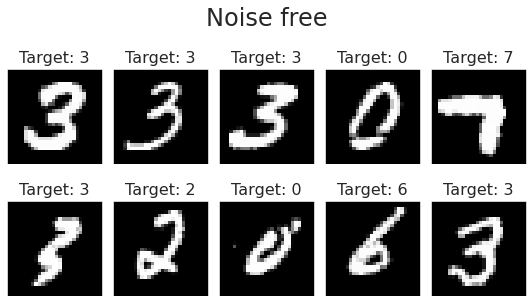

In [ ]:
show_ten_random(MNIST["train_data"], MNIST["train_targets"])

### Process data for noise experiments

To generate training data the images will be processed in the following way as follows

\begin{align} 
    \mathbf{Input}\colon x&, \, F, \, \tau \\
    x &← x - \mu(x) \\
    x &← \textrm{DCT}(x) \\
    Z &\sim \mathcal{N}(0, I) \\
    Z &← F \odot Z \\
    x &← x + \tau \; (||x|| / ||Z|| ) \; Z \\
    x &← \textrm{IDCT}(x) \\
    x &← x / ||x|| \\
    \mathbf{Output} \colon x
\end{align}

where $x \in \mathbb{R}^{28 \times 28}$, $\mu$ is the mean, $Z \sim \mathcal{N}(0, I)$ with $I \in \mathbb{R}^{28 \times 28}$ the unit matrix, $F$ is our filter matrix and $\tau$ is our chosen noise strength.

We define our high frequency filter matrix via:

$$
F_{ij}=
\begin{cases}
1 \qquad \mathrm{if} \; (28-i)^2 + (28-j)^2 \leq (28-1)^2 \\
0 \qquad \mathrm{otherwise}
\end{cases}
$$
for a quadratic image with height and width $28$.

For low-frequencies we will use the filter matrix we get by mirroing $F$ on the antidiagonal.

Notice that because our noise is normed and the signal constant our noise strength $\tau$ corrosponds directly to the signal to noise ratio.

#### Define noise filter function

First we implement a function, that for a given image adds gaussian noise to the certain frequency components of a discrete cosine transform and then applies an discrete inverse cosine tranform to get the filtered image.

In [ ]:
# Because type 3 dct (idct) is not yet implemented in JAX
# this part is written in numpy
def noise_2D(image: np.ndarray, F: np.ndarray, tau: float) -> np.ndarray:
    """
    Inserts noise into image.

    Args:
      image:
      An image in form a of an array with shape (28, 28).
      F: 
      The filter matrix.
      tau:
      The noisy intensity.

    Returns:
      An image with gaussian noisy of intensity tau added to the frequencies
      specified by F.
    """

    x = np.array(image)
    x = x - np.mean(x)
    x = x.reshape((28, 28))
    x = dct(dct(x, axis=0, norm="ortho"), axis=1, norm="ortho")
    Z = np.random.standard_normal((28, 28))
    Z = np.multiply(F, Z)
    x = x + tau * (sc.linalg.norm(x) / sc.linalg.norm(Z)) * Z
    x = idct(idct(x, axis=0, norm="ortho"), axis=1, norm="ortho")
    x = x / sc.linalg.norm(x)
    x = x.flatten()
    return x

In [ ]:
# Define filter matrix
F = np.zeros((28, 28))
for i in range(28):
    for j in range(28):
        if np.less_equal((28 - i) ** 2 + (28 - j) ** 2, (28 - 1) ** 2):
            F[i, j] = 1

tau = 1.0

def LF(image):
    return noise_2D(image, np.rot90(F,2).T, tau)

def HF(image):
    return noise_2D(image, F, tau)

noisy_train_images_LF = [LF(image) for image in MNIST["train_data"]]
noisy_train_images_HF = [HF(image) for image in MNIST["train_data"]]

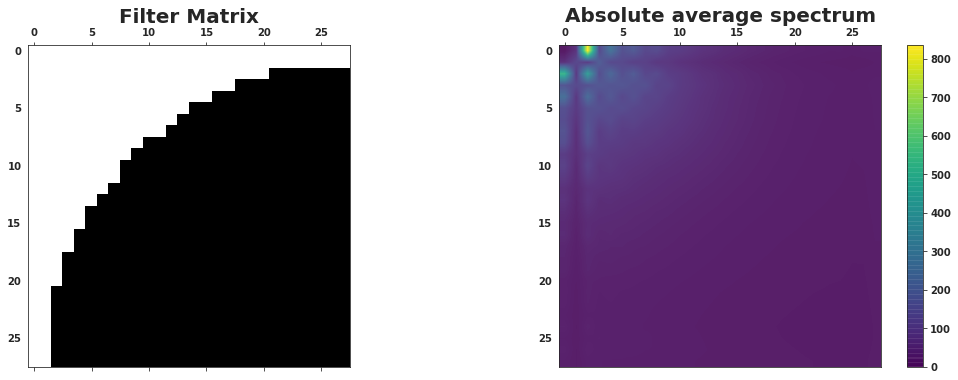

In [ ]:
filter_viz(F)

#### Let's see what the noisy images looks like

We visualize ten randomly chosen training images for a noise level of $\tau =1$

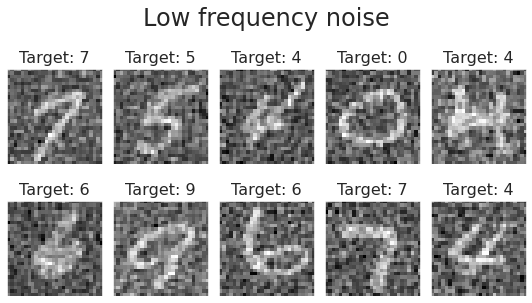

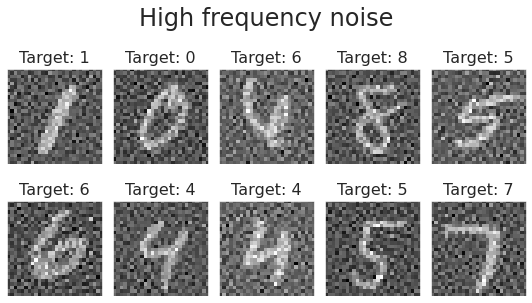

In [ ]:
show_ten_random(noisy_train_images_LF, MNIST["train_targets"], "Low frequency noise")
show_ten_random(noisy_train_images_HF, MNIST["train_targets"], "High frequency noise")

Now, what if we were to choose a much higher noise level like $\tau=5$ ?

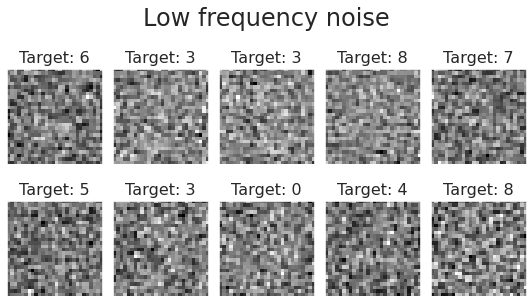

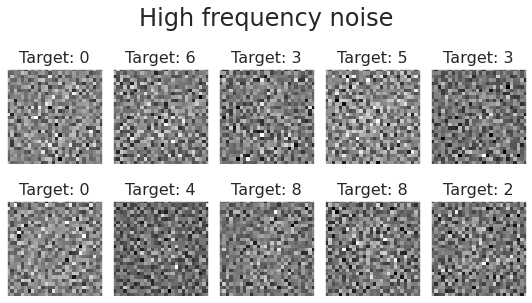

In [ ]:
tau = 5

noisy_train_images_LF = [LF(image) for image in MNIST["train_data"]]
noisy_train_images_HF = [HF(image) for image in MNIST["train_data"]]
show_ten_random(noisy_train_images_LF, MNIST["train_targets"], "Low frequency noise")
show_ten_random(noisy_train_images_HF, MNIST["train_targets"], "High frequency noise")

#### Insert noise into MNIST images

Now generate MNIST data with various levels of noise. Preparing the data beforehand leads to increased performance especially during multiple runs of experiments. Note that we include the noise level 0, which is identical to the original dataset, for consistency. 

In [ ]:
%%capture --no-display

noisy_MNIST_2D = []
tau_2D = [0, 2, 4, 6, 8]
for noisify in [LF, HF]:
  for tau in tau_2D:

      noisy_batch_size = 100

      noisy_MNIST = {}

      noisy_MNIST['one_hot'] = True
      noisy_MNIST["batch_size"] = noisy_batch_size
      noisy_MNIST["frequency"] = noisify.__name__
      noisy_MNIST['tau'] = tau

      # Create training data
      noisy_train_images = jnp.array(list(map(noisify, MNIST['train_data'])))

      # We have to keep the actual training data as Pytorch tensors for performance
      noisy_image_dataset = Imageset(th.from_numpy(np.array(noisy_train_images)), MNIST_train_dataset.targets)

      noisy_MNIST['train_data'] = noisy_train_images
      noisy_MNIST['train_loader'] = DataLoader(
            noisy_image_dataset, noisy_batch_size, shuffle=True, collate_fn=collate_fn, drop_last=True
        )
      noisy_MNIST['train_targets'] = MNIST['train_targets']

      # Create test data
      noisy_test_images = jnp.array(list(map(noisify, MNIST['test_data'])))

      # We have to keep the actual training data as Pytorch tensors for performance
      noisy_image_dataset = Imageset(th.from_numpy(np.array(noisy_train_images)), MNIST_train_dataset.targets)

      noisy_MNIST['test_data'] = noisy_test_images
      noisy_MNIST['test_loader'] = DataLoader(
            noisy_image_dataset, noisy_batch_size, shuffle=True, collate_fn=collate_fn, drop_last=True
        )
      noisy_MNIST['test_targets'] = MNIST['test_targets']

      noisy_MNIST_2D.append(noisy_MNIST)

#### Download and prepare MNIST-1D

In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")
import sys

path_to_module = "/content/gdrive/MyDrive/Data"
sys.path.append(path_to_module)
from MNIST_1D import gen_MNIST_1D, plot_signals
from MNIST_1D_freq import gen_MNIST_1D_freq

Mounted at /content/gdrive


In [ ]:
noisy_MNIST_1D = []
tau_1D = np.linspace(0.0, 0.5, 51)
for noise in ["Padding Noise", "Signal Noise"]:
    for tau in tau_1D:

        # Set batch size
        batch_size = 100

        if noise == "Padding Noise":
          raw_MNIST_1D = gen_MNIST_1D(noise=(tau, 0))
        else:
          raw_MNIST_1D = gen_MNIST_1D(noise=(0, tau))

        MNIST_1D = {}
        MNIST_1D["frequency"] = noise
        MNIST_1D["tau"] = tau
        MNIST_1D["one_hot"] = True
        MNIST_1D["batch_size"] = batch_size
        MNIST_1D["t"] = raw_MNIST_1D["t"]

        # DataLoaders will be used for neural network training
        MNIST_1D["train_loader"] = DataLoader(
            Imageset(
                th.from_numpy(raw_MNIST_1D["x"]), th.from_numpy(raw_MNIST_1D["y"])
            ),
            batch_size,
            shuffle=True,
            collate_fn=collate_fn,
            drop_last=True,
        )
        MNIST_1D["test_loader"] = DataLoader(
            Imageset(
                th.from_numpy(raw_MNIST_1D["x_test"]),
                th.from_numpy(raw_MNIST_1D["y_test"]),
            ),
            batch_size,
            shuffle=False,
            collate_fn=collate_fn,
            drop_last=True,
        )

        # JAX device arrays will be used for KRR and general calculations
        MNIST_1D["train_data"] = jnp.array(raw_MNIST_1D["x"]).reshape(
            len(raw_MNIST_1D["x"]), -1
        )
        MNIST_1D["train_targets"] = jnp.array(raw_MNIST_1D["y"])

        MNIST_1D["test_data"] = jnp.array(raw_MNIST_1D["x_test"]).reshape(
            len(raw_MNIST_1D["x_test"]), -1
        )
        MNIST_1D["test_targets"] = jnp.array(raw_MNIST_1D["y_test"])
        noisy_MNIST_1D.append(MNIST_1D)

In [ ]:
noisy_MNIST_1D_freq = []
tau_1D_freq = np.linspace(0.0, 5.0, 21)
for noise in ["Padding Noise", "Signal Noise"]:
    for tau in tau_1D_freq:

        # Set batch size
        batch_size = 100

        if noise == "Padding Noise":
          raw_MNIST_1D = gen_MNIST_1D_freq(noise=(tau, 0))
        else:
          raw_MNIST_1D = gen_MNIST_1D_freq(noise=(0, tau))

        MNIST_1D = {}
        MNIST_1D["frequency"] = noise
        MNIST_1D["tau"] = tau
        MNIST_1D["one_hot"] = True
        MNIST_1D["batch_size"] = batch_size
        MNIST_1D["t"] = raw_MNIST_1D["t"]

        # DataLoaders will be used for neural network training
        MNIST_1D["train_loader"] = DataLoader(
            Imageset(
                th.from_numpy(raw_MNIST_1D["x"]), th.from_numpy(raw_MNIST_1D["y"])
            ),
            batch_size,
            shuffle=True,
            collate_fn=collate_fn,
            drop_last=True,
        )
        MNIST_1D["test_loader"] = DataLoader(
            Imageset(
                th.from_numpy(raw_MNIST_1D["x_test"]),
                th.from_numpy(raw_MNIST_1D["y_test"]),
            ),
            batch_size,
            shuffle=False,
            collate_fn=collate_fn,
            drop_last=True,
        )

        # JAX device arrays will be used for KRR and general calculations
        MNIST_1D["train_data"] = jnp.array(raw_MNIST_1D["x"]).reshape(
            len(raw_MNIST_1D["x"]), -1
        )
        MNIST_1D["train_targets"] = jnp.array(raw_MNIST_1D["y"])

        MNIST_1D["test_data"] = jnp.array(raw_MNIST_1D["x_test"]).reshape(
            len(raw_MNIST_1D["x_test"]), -1
        )
        MNIST_1D["test_targets"] = jnp.array(raw_MNIST_1D["y_test"])
        noisy_MNIST_1D_freq.append(MNIST_1D)

#### Visualize MNIST-1D at various noise levels

The MNSIT-1D dataset is a synthetic dataset designed for Science of Deep Learning experiments. It represents an abstraction of the digits of the original MNIST dataset. The data is presented in a time series-like format.

It contains 4000x40 training instances and 1000x40 test instances. The main advantage is that it represents a low computationally intensive dataset, which at the same time acts as a sharp discriminator of machine learning models.

To the signal part which is a simplification of a digit, padding is added. In the following we will inject noise in different strengths in both the signal as well as the padding part of the data and see whether there is any qualitative difference in model performances.

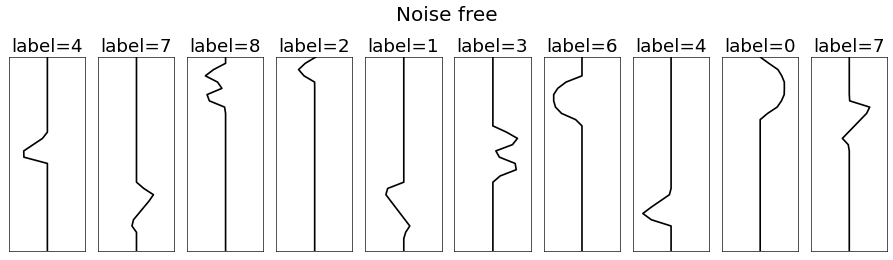

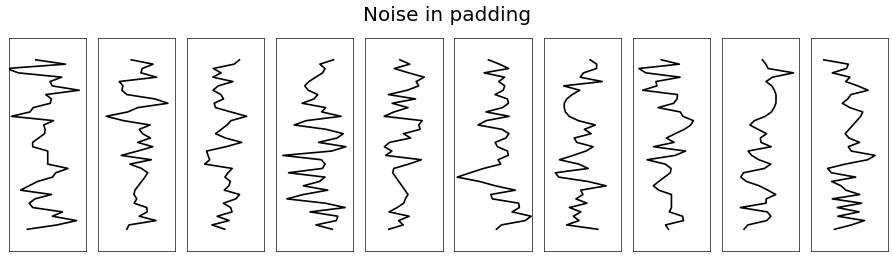

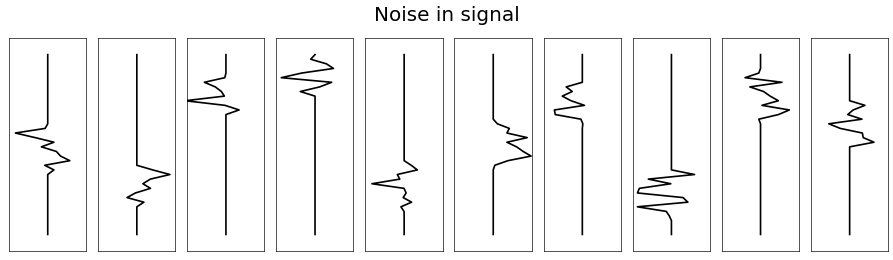

In [ ]:
plot_signals(
    noisy_MNIST_1D[0]["train_data"],
    noisy_MNIST_1D[0]["t"],
    noisy_MNIST_1D[0]["train_targets"],
    zoom = 6,
)

plot_signals(noisy_MNIST_1D[50]["train_data"], noisy_MNIST_1D[50]["t"], zoom = 3, title = "Noise in padding")

plot_signals(noisy_MNIST_1D[100]["train_data"], noisy_MNIST_1D[100]["t"], zoom = 5, title = "Noise in signal")

We also do the same in the frequency domain, in which we set the signal to be on low frequencies and pad higher frequencies.

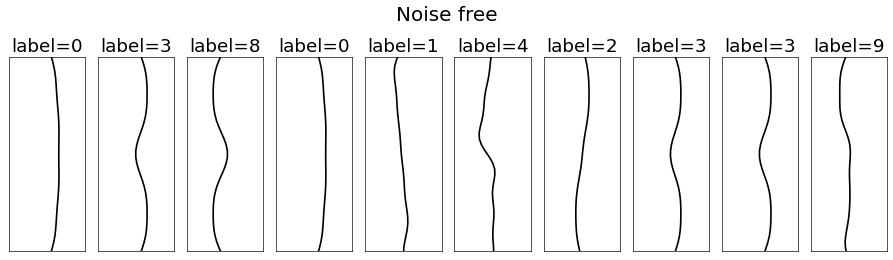

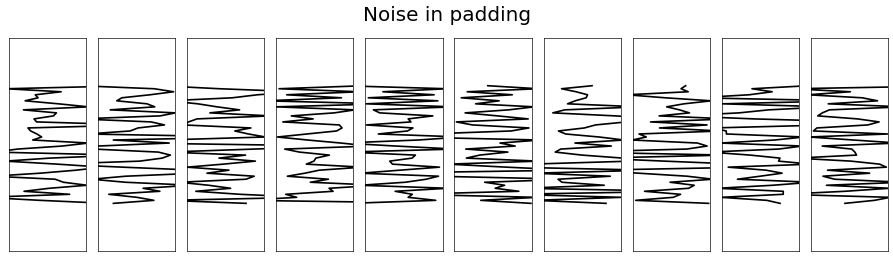

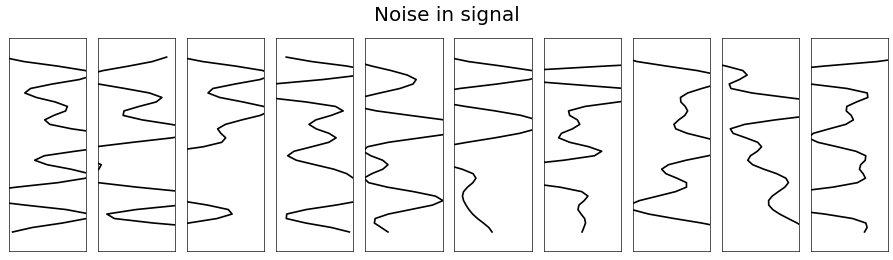

In [ ]:
plot_signals(
    noisy_MNIST_1D_freq[0]["train_data"],
    noisy_MNIST_1D_freq[0]["t"],
    noisy_MNIST_1D_freq[0]["train_targets"],
    zoom = 6,
)

plot_signals(noisy_MNIST_1D_freq[10]["train_data"], noisy_MNIST_1D_freq[10]["t"], zoom = 1.5, title = "Noise in padding")

plot_signals(noisy_MNIST_1D_freq[30]["train_data"], noisy_MNIST_1D_freq[30]["t"], zoom = 1.5, title = "Noise in signal")

## Models <a name="models"></a>

**Four types of models**

For both data sets:
*   Two layer neural network with hidden layer size 4096, ReLU activations, trained with ADAM according to a cosine decay schedule with linear warm up.

For MNIST-1D:
*   Neural tangent kernel associated with the network, calculated by the neural tangents library.
*   Kernel ridge regression implemented in JAX.

For MNIST:
*   Support vector classifier implemented in scikit-learn.





#### Performance metrics

We define two performance metrics. One is the Mean Squared Error:

$$\frac{1}{n} \sum\limits_{i=1}^{n} (\hat{y}_i - y_i)^2$$

This will be our objective function with which we will train the network and the kernel ridge regression.

Additionally we define the Accuracy:

$$\frac{1}{n} \sum\limits_{i=1}^{n} (\hat{y}_i \wedge y_i)$$

##### Implement performance metrics

In [ ]:
@jit
def accuracy(pred_targets: Array, targets: Array):
    """Calculate accuracy of MLP"""
    pred_targets = jnp.argmax(pred_targets, axis=1)
    return jnp.mean(targets == pred_targets)


@jit
def loss(pred_targets: Array, targets: Array):
    """Calculate mean square error"""
    if pred_targets.shape[1] > 1:
        targets = jax.nn.one_hot(targets, 10)
    err = pred_targets - targets
    return jnp.mean(jnp.square(err))


@jit
def accuracy_fn(params: Array, images: Array, targets: Array):
    """Calculate accuracy of MLP"""
    pred_targets = jnp.argmax(batched_forward(params, images), axis=1)
    return jnp.mean(targets == pred_targets)


@jit
def loss_fn(params: Array, images: Array, targets: Array):
    """Calculate mean square error for MLP"""
    pred_targets = batched_forward(params, images)
    if pred_targets.shape[1] > 1:
        targets = jax.nn.one_hot(targets, 10)
    err = pred_targets - targets
    return jnp.mean(jnp.square(err))

### Pure JAX Neural Network

In this section we will develop a multilayer perceptron model in pure JAX without addtional libraries. This will give us great control over the network architecture and show us the inner workings of neural network training.

#### Multilayer Perceptron Model

For our neural network we will use a fully connected multilayer perceptron.

In [ ]:
def init_layer(
    in_width: int, out_width: int, key: KeyArray, scale: float = 1e-2
) -> Union[Array, Array]:
    """
    Initializes one layer of a multilayer perceptron.

    Args:
      in_width:
        Input dimension of the layer.
      out_width: 
        Output dimension of the layer.
      key:
        The random state.
      scale:
        Scaling factor for the weights.

    Returns:
      A 2-tuple consisting of arrays representing weights and biases of the layer.
    """

    key, subkey = random.split(key)
    weights = scale * random.normal(
        subkey, (out_width, in_width)
    )  # simple scaling seems to lead to faster convergence
    bias = jnp.zeros(out_width)
    return weights, bias


def init_mlp(layers: List[int], key: KeyArray) -> List[Array]:
    """
    Initializes a multilayer perceptron.

    Args:
      layers:
        Numbers of neurons in each layer.
      key:
        The random state.

    Returns:
      A list of tuples containing the weights and biases of each layer of the mlp.
    """

    key, *keys = random.split(key, len(layers))
    params = list(map(init_layer, layers[:-1], layers[1:], keys))
    return params

In the next section we will define the forward pass or forward of the neural network. The forward pass refers to the calculation of output values from data. From a mathematical point of view this is nothing else than applying the neural network as a function.

Given a two layer neural network with input dimension $d_{in}$, hidden layer size $n$ and output dimension $d_{out}$, we can define the forward pass mathematically as:

$$\Phi_k(x;w,b) = \sum\limits_{i=1}^{d_{out}} w_k^i \sigma\left(\sum\limits_{j=1}^{n} w_{jk}^i + b_k^i \right)$$

where $\sigma$ is the activation function of the network. Throughout this notebook we will utilize the rectified linear unit (ReLU):

$$\sigma(x) = \max\{0, x\}$$

Note also, that we  keep the last layer of our multilayer perceptron linear.

In [ ]:
def forward(params: Tuple, x: Array) -> Array:
    """
    Calculations the forward pass of the mlp.

    Args:
      params:
        The parameters of the multilayer perceptron.
      x:
        A single instance of input data.

    Returns:
      The prediction of the neural network given input x.
    """
    activation = x

    for weight, bias in params[:-1]:
        activation = jax.nn.relu(jnp.dot(weight, activation) + bias)

    weight_last, bias_last = params[-1]
    logits = jnp.dot(weight_last, activation) + bias_last
    return logits


# vectorize forward function for batches
batched_forward = vmap(forward, in_axes=(None, 0))

In [ ]:
@jit
def update(params: Tuple, data: Array, target: Array) -> Union[Tuple, float]:
    """Update parameters by taking one gradient step

    Args:
      params:
        The parameters of the multilayer perceptron.
      data:
        A batch of training data.
      target:
        A batch of targets corrosponding to the training data.

    Returns:
      The updated parameters and current value of the objective function.
    """

    loss, grads = value_and_grad(loss_fn)(params, data, target)
    params = jax.tree_multimap(lambda p, g: p - learning_rate * g, params, grads)
    return params, loss

Next we define the actual training loop for the neural network given MNIST data.

In [ ]:
def pure_jax_training_loop(
    data: Array,
    epochs: int,
    params: Tuple,
    learning_rate: float,
    accuracy: bool = False,
) -> Union[List, List, List, List]:
    """
    Trains a multilayer perceptron model build in pure jax.

    Args:
      data:
        Training and test data.
      epochs:
        The number of epochs the loop is to run. One iteration over all batches
        in the DataLoader corresponds to one epoch.
      params:
        The initial parameters of the mlp to be trained.
      learning_rate:
        The learning rate, or stepsize, used during gradient descent.
      accuracy:
        A boolean that determines whether accuracy should be computed.


    Returns:
      List representing the logs of the performance metrics during training.
    """

    # Set up lists for logging
    log_train_loss, log_test_loss, log_train_acc, log_test_acc = [], [], [], []

    # Log training and test loss for intial parameters
    train_loss = loss_fn(params, data["train_data"], data["train_targets"])
    test_loss = loss_fn(params, data["test_data"], data["test_targets"])

    # Log training and test accuracy for intial parameters
    if accuracy:
        train_acc = accuracy_fn(params, data["train_data"], data["train_targets"])
        test_acc = accuracy_fn(params, data["test_data"], data["test_targets"])
        log_train_acc.append(train_acc)
        log_test_acc.append(test_acc)

        print(
            "Epoch {:2.0f} | Duration: 0.00 | Train Accuracy: {:0.3f} | Test Accuracy: {:0.3f} | Train Loss: {:0.4e} | Test Loss: {:0.4e}".format(
                0, train_acc, test_acc, train_loss, test_loss
            )
        )
    else:
        print(
            "Epoch {:2.0f} | Duration: 0.00 | Train Loss: {:0.4e} | Test Loss: {:0.4e}".format(
                0, train_loss, test_loss
            )
        )

    # Loop over training data epochs times
    for epoch in range(epochs):
        start_time = time.perf_counter()

        # Loop over all training batches
        for batch_idx, (instance, target) in enumerate(data["train_loader"]):
            params, loss = update(params, instance, target)

        end_time = time.perf_counter()
        epoch_time = end_time - start_time

        # Log training and test accuracy for each epoch
        train_loss = loss_fn(params, data["train_data"], data["train_targets"])
        test_loss = loss_fn(params, data["test_data"], data["test_targets"])
        log_train_loss.append(train_loss)
        log_test_loss.append(test_loss)

        if accuracy:
            train_acc = accuracy_fn(params, data["train_data"], data["train_targets"])
            test_acc = accuracy_fn(params, data["test_data"], data["test_targets"])
            log_train_acc.append(train_acc)
            log_test_acc.append(test_acc)
            print(
                "Epoch {:2.0f} | Duration: {:0.2f} | Train Accuracy: {:0.3f} | Test Accuracy: {:0.3f} | Train Loss: {:0.4e} | Test Loss: {:0.4e}".format(
                    epoch + 1, epoch_time, train_acc, test_acc, train_loss, test_loss
                )
            )
        else:
            print(
                "Epoch {:2.0f} | Duration: {:0.2f} | Train Loss: {:0.4e} | Test Loss: {:0.4e}".format(
                    epoch + 1, epoch_time, train_loss, test_loss
                )
            )

    return log_train_loss, log_test_loss, log_train_acc, log_test_acc

#### Test Multilayer perceptron on MNIST

In [ ]:
# Hyperparameters
learning_rate = 1e-4
epochs = 50
layers = [784, 4096, 10]

key, subkey = random.split(key)
params = init_mlp(layers, subkey)

train_loss, test_loss, train_acc, test_acc = pure_jax_training_loop(
    MNIST, epochs, params, learning_rate=learning_rate, accuracy=True,
)

Epoch  0 | Duration: 0.00 | Train Accuracy: 0.109 | Test Accuracy: 0.107 | Train Loss: 6.9509e+01 | Test Loss: 7.0119e+01
Epoch  1 | Duration: 5.01 | Train Accuracy: 0.323 | Test Accuracy: 0.327 | Train Loss: 1.0243e-01 | Test Loss: 1.0003e-01
Epoch  2 | Duration: 4.64 | Train Accuracy: 0.496 | Test Accuracy: 0.497 | Train Loss: 7.7893e-02 | Test Loss: 7.7030e-02
Epoch  3 | Duration: 4.59 | Train Accuracy: 0.576 | Test Accuracy: 0.576 | Train Loss: 6.4660e-02 | Test Loss: 6.4324e-02
Epoch  4 | Duration: 4.62 | Train Accuracy: 0.621 | Test Accuracy: 0.621 | Train Loss: 5.7141e-02 | Test Loss: 5.7007e-02
Epoch  5 | Duration: 4.61 | Train Accuracy: 0.658 | Test Accuracy: 0.657 | Train Loss: 5.2347e-02 | Test Loss: 5.2504e-02
Epoch  6 | Duration: 4.62 | Train Accuracy: 0.695 | Test Accuracy: 0.689 | Train Loss: 4.8282e-02 | Test Loss: 4.8639e-02
Epoch  7 | Duration: 4.60 | Train Accuracy: 0.727 | Test Accuracy: 0.721 | Train Loss: 4.4422e-02 | Test Loss: 4.4826e-02
Epoch  8 | Duration: 4.6

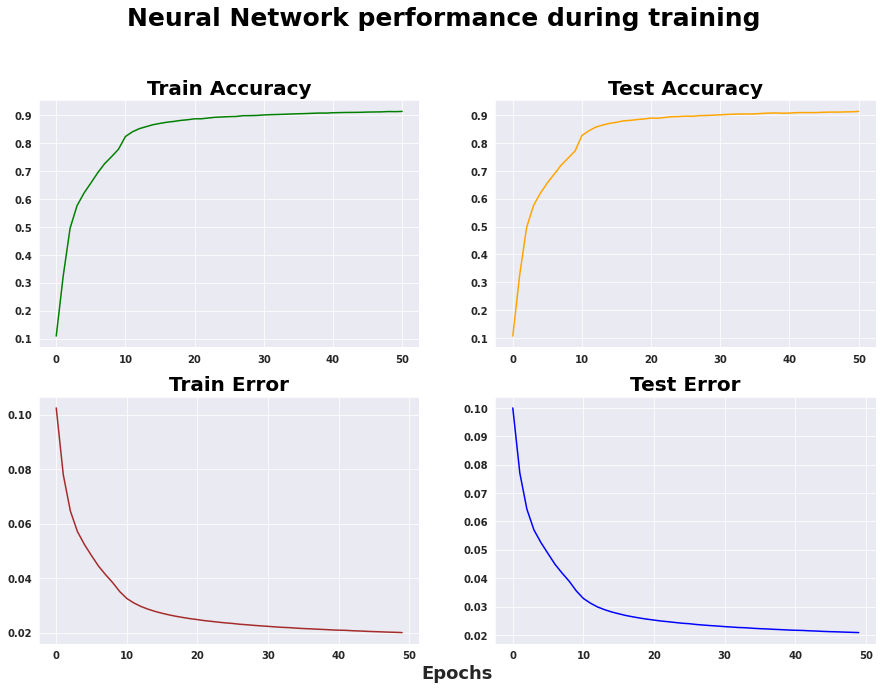

In [ ]:
plt_nn_training(train_acc, test_acc, train_loss, test_loss)

#### Test Multilayer perceptron on synthetic data

First we generate some synthetic data for a test run

In [ ]:
kappa = 0.1
n = 10000
batch_size = 1000

key, subkey = random.split(key)
synth_data = gen_synth(subkey, kappa, n, batch_size)

Then run Neural Network on the synthetic data

In [ ]:
# Hyperparameters
learning_rate = 1e-4
epochs = 20
layers = [1024, 4096, 1]

key, subkey = random.split(key)
params = init_mlp(layers, subkey)

train_loss, test_loss, _, _ = pure_jax_training_loop(
    synth_data, epochs, params, learning_rate=learning_rate, accuracy=False,
)

Epoch  0 | Duration: 0.00 | Train Loss: 3.5975e-01 | Test Loss: 3.6758e-01
Epoch  1 | Duration: 0.55 | Train Loss: 1.4249e-01 | Test Loss: 1.4430e-01
Epoch  2 | Duration: 0.05 | Train Loss: 1.0202e-01 | Test Loss: 1.0221e-01
Epoch  3 | Duration: 0.05 | Train Loss: 8.1257e-02 | Test Loss: 8.0925e-02
Epoch  4 | Duration: 0.05 | Train Loss: 6.7642e-02 | Test Loss: 6.7105e-02
Epoch  5 | Duration: 0.05 | Train Loss: 5.8431e-02 | Test Loss: 5.7807e-02
Epoch  6 | Duration: 0.05 | Train Loss: 5.2135e-02 | Test Loss: 5.1480e-02
Epoch  7 | Duration: 0.05 | Train Loss: 4.7783e-02 | Test Loss: 4.7129e-02
Epoch  8 | Duration: 0.05 | Train Loss: 4.4732e-02 | Test Loss: 4.4096e-02
Epoch  9 | Duration: 0.05 | Train Loss: 4.2550e-02 | Test Loss: 4.1944e-02
Epoch 10 | Duration: 0.05 | Train Loss: 4.0952e-02 | Test Loss: 4.0383e-02
Epoch 11 | Duration: 0.05 | Train Loss: 3.9748e-02 | Test Loss: 3.9217e-02
Epoch 12 | Duration: 0.05 | Train Loss: 3.8809e-02 | Test Loss: 3.8318e-02
Epoch 13 | Duration: 0.05

### STAX and OPTAX Neural Network

#### Define neural network model

In this section we set up a multilayer perceptron model programmed with the help of STAX. STAX is a library that provides a convinient way to formulate serial models.

In our case we will use the STAX version implemented in the neural-tangent liberary to get the neural tangent kernel associated to a given neural network.

In [ ]:
def two_layer_nn(
    batch_size: float,
    hidden_width: int = 4096,
    out_width: int = 10,
    in_width: int = 784,
    key: KeyArray = random.PRNGKey(42),
) -> Union[Array, Callable, Callable]:
    """
    Initializes a two layer multi layer perceptron. The weights and biases
    are initialized according to neural tangent initialization.

    Args:
      hidden_width:
        Number of neurons in the hidden layer.
      in_width: 
        Input dimension of the layer.
      out_width: 
        Output dimension of the layer.
      key:
        The random state.

    Returns:
      Initial parameters of the mlp, the forward pass of the mlp and
      the kernel function associated with the architecture. The kernel function
      can be used to compute both neural tangent kernel,
      as well as neural network gaussian process kernel.
    """

    init_fn, apply_fn, kernel_fn = stax.serial(
        stax.Dense(hidden_width), stax.Relu(), stax.Dense(out_width)
    )

    _, params = init_fn(key, (batch_size, in_width))
    return params, apply_fn, kernel_fn

In [ ]:
def ntk_fn(
    apply_fn: Callable,
    kernel_fn: Callable,
    params: Tuple,
    data: Array,
    learning_rate: float,
) -> Union[Array, Array]:
    """
    Sets up a neural tangent kernel and uses it to predict
    targets of both training and test data.

    Args:
      apply_fn:
        The forward pass function of a neural network.
      kernel_fn:
        The kernel function associated to a neural network.
     data:
        Training and test data.

    Returns:
      Predictions interfered by the neural tangent kernel.
    """

    kernel = nt.batch(kernel_fn, device_count=-1, batch_size=data["batch_size"])

    # Generate empirical kernel
    ntk_train_train = kernel(data["train_data"], None, "ntk")
    ntk_test_train = kernel(data["test_data"], data["train_data"], "ntk")

    # Derive prediction function from analytical solution of ntk trained by SGD
    if data["one_hot"]:
        train_targets = jax.nn.one_hot(data["train_targets"], 10)
    else:
        train_targets = data["train_targets"]
    predict = nt.predict.gradient_descent_mse(
        ntk_train_train, train_targets, learning_rate=learning_rate,
    )
    # Get initial targets for ntk
    ntk_train_0 = apply_fn(params, data["train_data"])
    ntk_test_0 = apply_fn(params, data["test_data"])

    # Get ntk prediction
    ntk_yhat_train, ntk_yhat_test = predict(
        t=None,  # None equals training for infinite time
        fx_train_0=ntk_train_0,
        fx_test_0=ntk_test_0,
        k_test_train=ntk_test_train,
    )
    return ntk_yhat_train, ntk_yhat_test

In [ ]:
def training_loop(
    data: Array,
    epochs: int,
    params: Tuple,
    forward: Callable,
    initial_learning_rate: float,
    verbose: bool = False,
    calc_acc: bool = False,
) -> Union[List, List, List, List, Array]:
    """
    Trains a multilayer perceptron model build in the neural tangents
    implementation of stax and calculations the corrosponding empirical neural
    tangents kernel given the current parameters of the network.

    Args:
      data:
        Training and test data.
      epochs:
        The number of epochs the loop is to run. One iteration over all batches
        in the DataLoader corresponds to one epoch.
      params:
        The initial parameters of the mlp to be trained.
      initial_learning_rate:
        The initial learning rate used during gradient descent. 
        This value serves as the starting point of the scheduler.
        The schedule determines the evolution of the learning rate during training.
      forward:
        The forward pass function of the instatiated mlp architecture.
      verbose:
        A boolean that determines whether to print performances during training.
      accuracy:
        A boolean that determines whether accuracy should be computed.

    Returns:
      List representing the logs of the performance metrics during training 
      and the final paramaters of the neural network.
    """

    @jit
    def loss_fn(params, data, target):
        """Calculate mean square error of MLP predictions"""
        target_pred = forward(params, data)
        if target_pred.shape[1] > 1:
            target = jax.nn.one_hot(target, 10)
        loss = jnp.mean(optax.l2_loss(target_pred, target))
        return loss

    @jit
    def update(params, data, target, opt_state):
        """Update parameters by taking one gradient step"""
        loss, grad = value_and_grad(loss_fn)(params, data, target)
        updates, opt_state = gradient_transform.update(grad, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss

    # Cosine decay of the learning rate with warm up period
    scheduler = optax.warmup_cosine_decay_schedule(
        init_value=initial_learning_rate,
        peak_value=1 / 15,
        warmup_steps=15 * len(data["train_loader"]),
        decay_steps=epochs * len(data["train_loader"]),
    )

    # Combining gradient transforms using optax.chain
    gradient_transform = optax.chain(
        optax.clip_by_global_norm(1.0),
        optax.scale_by_adam(),
        optax.add_decayed_weights(0.001),
        optax.scale_by_schedule(scheduler),
        optax.scale(-1.0),
    )

    opt_state = gradient_transform.init(params)

    log_train_loss, log_test_loss, log_ntk_train_loss, log_ntk_test_loss = (
        [],
        [],
        [],
        [],
    )
    log_train_acc, log_test_acc, log_ntk_train_acc, log_ntk_test_acc = [], [], [], []

    # Loop over training data
    for epoch in range(epochs):
        start_time = time.perf_counter()
        for batch_idx, (instance, target) in enumerate(data["train_loader"]):
            params, opt_state, train_loss = update(params, instance, target, opt_state)

        train_loss = loss_fn(params, data["train_data"], data["train_targets"])
        test_loss = loss_fn(params, data["test_data"], data["test_targets"])
        log_train_loss.append(train_loss)
        log_test_loss.append(test_loss)

        train_acc = accuracy(forward(params, data["train_data"]), data["train_targets"])
        test_acc = accuracy(forward(params, data["test_data"]), data["test_targets"])

        log_train_acc.append(train_acc)
        log_test_acc.append(test_acc)

        end_time = time.perf_counter()
        epoch_time = end_time - start_time

        if verbose:
            if calc_acc:
                print(
                    "Epoch {:2.0f} | Duration: {:0.2f} | NN Train Accuracy: {:0.3f} | "
                    "NN Accuracy: {:0.3f}".format(
                        epoch + 1, epoch_time, train_acc, test_acc,
                    )
                )
            else:
                print(
                    "Epoch {:2.0f} | Duration: {:0.2f} | NN Train Loss: {:0.4e} | "
                    "NN Test Loss: {:0.4e}".format(
                        epoch + 1, epoch_time, train_loss, test_loss,
                    )
                )

    return (
        log_train_loss,
        log_test_loss,
        log_train_acc,
        log_test_acc,
        params,
    )

#### Test neural network and neural tangent kernel

Now let us try out this new architecture and also see how it compares to its neural tangent kernel. For that we will use the MNIST-1D dataset.

In [ ]:
# Hyperparameters
learning_rate = 1e-3
epochs = 100
init_params, forward, kernel = two_layer_nn(
    batch_size=noisy_MNIST_1D[0]["batch_size"], in_width=40
)

(
    log_train_loss,
    log_test_loss,
    log_train_acc,
    log_test_acc,
    final_params,
) = training_loop(
    noisy_MNIST_1D[0],
    epochs,
    init_params,
    forward=forward,
    initial_learning_rate=learning_rate,
    verbose=False,
    calc_acc=True,
)

yhat_train_init, yhat_test_init = ntk_fn(
    forward, kernel, init_params, noisy_MNIST_1D[0], learning_rate,
)

print(
    "Accuracy {:0.3f} NN train | Accuracy {:0.3f} NTK train".format(
        log_train_acc[-1], accuracy(yhat_train_init, noisy_MNIST_1D[0]["train_targets"])
    )
)
print(
    "Accuracy {:0.3f} NN test  | Accuracy {:0.3f} NTK test".format(
        log_test_acc[-1], accuracy(yhat_test_init, noisy_MNIST_1D[0]["test_targets"])
    )
)

Accuracy 1.000 NN train | Accuracy 1.000 NTK train
Accuracy 1.000 NN test  | Accuracy 0.101 NTK test


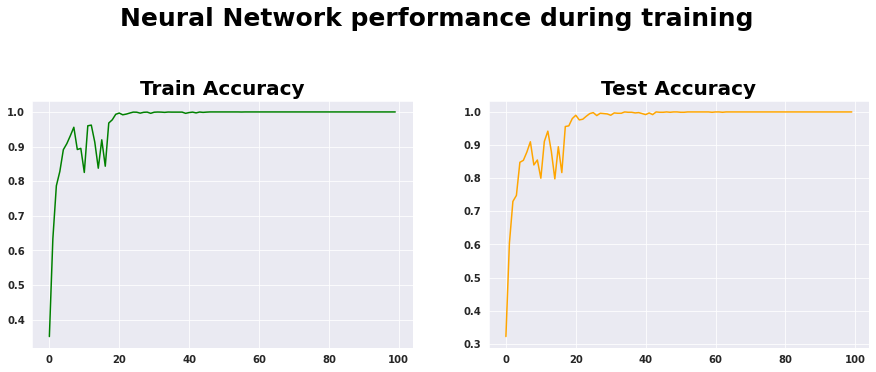

In [ ]:
plt_nn_training(log_train_acc, log_test_acc)

### Kernel Ridge Regression

#### Define kernel ridge regression method

In [ ]:
@partial(jit, static_argnums=(6, 7,))
def krr(
    train_data: Array,
    test_data: Array,
    train_targets: Array,
    d: int,
    lambda_: float,
    params: Union[float, Tuple[float, float]],
    kernel: str,
) -> Union[Array, Array]:
    """
    Uses kernel ridge regression to predict targets given training and test data.

    Args:
      data:
        Training and test data.
      lambda_:
        Tikhonov factor for regularization in kernel ridge regression.
      kernel:
        The type of feature map to be used.

    Returns:
      Target predictions for training and test data.

    Raises:
      Invalid kernel: A non-implemented kernel type was chosen.
    """

    def polynomial(z, params):
        """Polynomial kernel function"""
        c, d = params
        return jnp.power(z + c, d)

    def rbf(z, params):
        """radial basis kernel function"""
        length_scale = params
        return jnp.exp(-z / jnp.square(length_scale))

    if kernel == "polynomial":
        k = jit(polynomial)
    elif kernel == "rbf":
        k = jit(rbf)
    else:
        raise Exception("Invalid kernel")

    def gram(P, Q, h, d, params):
        """Generate Gram matrix for kernel"""
        g = vmap(h, in_axes=(0, None))
        return g(jnp.dot(P, jnp.transpose(Q)) / d, params)

    def regularize(G, reg):
        """Regularize by adding constant on diagonal without in-place updates"""
        N, _ = G.shape
        i, j = jnp.diag_indices(N)
        return G.at[i, j].set(G[i, j] + reg)

    def gram_func(P, Q):
        return gram(P, Q, k, d, params)

    # Generate Gram matrices for training and test data
    gram_train = gram_func(train_data, train_data)
    gram_test = gram_func(test_data, train_data)

    regularized_gram_train = regularize(gram_train, lambda_)

    beta = jnp.linalg.solve(regularized_gram_train, train_targets)

    # Generate predictions from kernel ridge regression
    yhat_train = jnp.dot(gram_train, beta)
    yhat_test = jnp.dot(gram_test, beta)

    return yhat_train, yhat_test

#### Hyperparameter tuning

##### Perform 10-fold crossvalidation for MNIST-1D Polynomial KRR.

Next we perform hyperparamater tuning for both gaussian and polynomial kernels. Because kernel ridge regression is very memory intensive we will implement this serial via several loops instead of vectorizing it.

In [ ]:
def is_nan(x: Any) -> bool:
    return (x is np.nan or x != x)

In [ ]:
def rbf_tuning(data: Array, k: float = 0.1) -> Union[Dict, List[Dict]]:
    """
    Runs k fold cross validation to optimize hyperparameters
    of rbf kernel regression.     

    Args:
      data:
        Training dataset to optimize hyperparameters on. 
      k:
        Proportion of the training data to be used for cross validation.

    Returns:
      Dict with optimal parameters and loss values,
      as well as list of all parameters logs.
    """
    logs = []
    for lambda_ in [0.0, 0.001, 0.01, 0.1, 1, 10]:
        for gamma in [0.0, 0.001, 0.01, 0.1, 1, 10]:
            log = {"lambda": lambda_, "params": gamma}

            (
                train_data,
                validation_data,
                train_targets,
                validation_targets,
            ) = train_test_split(data["train_data"], data["train_targets"], test_size=k)

            if data["one_hot"]:
                krr_train_targets = jax.nn.one_hot(train_targets, 10)
            else:
                krr_train_targets = train_targets

            yhat_train, yhat_val = krr(
                train_data=train_data,
                test_data=validation_data,
                train_targets=krr_train_targets,
                d=2,
                lambda_=lambda_,
                params=gamma,
                kernel="rbf",
            )

            # Log errors
            log["train_accuracy"] = accuracy(yhat_train, train_targets)
            log["validation_accuracy"] = accuracy(yhat_val, validation_targets)
            logs.append(log)
    return (
        sorted(
            logs,
            key=lambda d: float("-inf")
            if is_nan(d["validation_accuracy"])
            else d["validation_accuracy"],
        )[-1]["params"],
        logs,
    )

In [ ]:
def polynomial_tuning(data: Array, k: float = 0.1) -> Union[Dict, List[Dict]]:
    """
    Runs k fold cross validation to optimize hyperparameters
    of polynomial kernel regression.     

    Args:
      data:
        Training dataset to optimize hyperparameters on. 
      k:
        Proportion of the training data to be used for cross validation.

    Returns:
      Dict with optimal parameters and loss values,
      as well as list of all parameters logs.
    """
    logs = []
    for lambda_ in [0.0, 0.001, 0.01, 0.1, 1, 10]:
        for c in range(11):
            for n in range(11):
                params = (c, n)
                log = {"lambda": lambda_, "params": params}

                (
                    train_data,
                    validation_data,
                    train_targets,
                    validation_targets,
                ) = train_test_split(
                    data["train_data"], data["train_targets"], test_size=k
                )

                if data["one_hot"]:
                    krr_train_targets = jax.nn.one_hot(train_targets, 10)
                else:
                    krr_train_targets = train_targets

                yhat_train, yhat_val = krr(
                    train_data=train_data,
                    test_data=validation_data,
                    train_targets=krr_train_targets,
                    d=2,
                    lambda_=lambda_,
                    params=params,
                    kernel="polynomial",
                )

                # Log errors
                log["train_error"] = loss(yhat_train, train_targets)
                log["validation_error"] = loss(yhat_val, validation_targets)
                logs.append(log)

    opt = sorted(
              logs,
              key=lambda d: float("inf")
              if is_nan(d["validation_error"])
              else d["validation_error"],
            )[0]
    opt_params = opt["params"]
    opt_lambda = opt["lambda"]

    return (
        opt_lambda,
        opt_params,
        logs,
    )

In [ ]:
noise_lambda, noise_params, noise_params_log = polynomial_tuning(noisy_MNIST_1D[0])

#synth_lambda, synth_params, synth_params_log = polynomial_tuning(synth_data)

In [ ]:
print(noise_params)

print(noise_lambda)

(6, 3)
10


##### Result of 10-fold crossvalidation

Based on our crossvalidation we will set the intercept $c=6$ and the degree $n=3$, so that our polynomial kernel is of the form $K(x, y) = (\langle x, \, y \rangle + 6)^3$. As Tikhonov regularization factor we choose $\lambda = 10$.

## Noise data experiments <a name="noise"></a>

#### Define noise experiment for MNIST 1D

In [ ]:
def run_noise_experiments_1D(
    noisy_data: List[Dict], key: KeyArray = random.PRNGKey(1789),
) -> Union[List, List, List, List, List, List]:
    """
    Runs experiments comparing the performance of mlps and kernel methods 
    on MNIST-1D training data injected with additive gaussian on noise
    on the high frequency modes of a discrete cosine transform.

    Args:
       noisy_data:
        A list containing MNIST-1D datasets with various noisy levels injected.
      key:
        The random state for the experiments to be run in. 
        The state should be fixed for experiments to guarantee 
        consistency of the experiments. 

    Returns:
      List representing the logs of the accuracy of kernel ridge regression and
      fully trained neural networks during training.
    """

    learning_rate = 1e-3
    epochs = 100

    (
        log_krr_train_acc,
        log_krr_test_acc,
        log_ntk_train_acc,
        log_ntk_test_acc,
        log_nn_train_acc,
        log_nn_test_acc,
    ) = (
        [],
        [],
        [],
        [],
        [],
        [],
    )

    for data in noisy_data:

        freq = data["frequency"]
        tau = data["tau"]

        one_hot = jit(vmap(lambda x: jax.nn.one_hot(x, 10)))
        train_one_hot = one_hot(data["train_targets"])
        test_one_hot = one_hot(data["test_targets"])

        params, forward, kernel = two_layer_nn(batch_size=data['batch_size'], in_width=40)

        # Train neural network on noisy data
        (
            log_train_loss,
            log_test_loss,
            log_train_acc,
            log_test_acc,
            params,
        ) = training_loop(
            data,
            epochs,
            params,
            forward,
            initial_learning_rate=learning_rate,
            verbose=False,
        )

        # Perform kernel ridge regression for noisy data
        yhat_train, yhat_test = krr(
            data["train_data"],
            data["test_data"],
            train_one_hot,
            d=2,
            lambda_=noise_lambda,
            params=noise_params,
            kernel="polynomial",
        )

        yhat_train_ntk, yhat_test_ntk = ntk_fn(
            forward, kernel, params, data, learning_rate,
        )
        # Log accs
        krr_train_acc = accuracy(yhat_train, data["train_targets"])
        krr_test_acc = accuracy(yhat_test, data["test_targets"])
        ntk_train_acc = accuracy(yhat_train_ntk, data["train_targets"])
        ntk_test_acc = accuracy(yhat_test_ntk, data["test_targets"])
        nn_train_acc = accuracy(
            forward(params, data["train_data"]), data["train_targets"]
        )
        nn_test_acc = accuracy(
            forward(params, data["test_data"]), data["test_targets"]
        )

        log_krr_train_acc.append(krr_train_acc)
        log_krr_test_acc.append(krr_test_acc)
        log_ntk_train_acc.append(ntk_train_acc)
        log_ntk_test_acc.append(ntk_test_acc)
        log_nn_train_acc.append(nn_train_acc)
        log_nn_test_acc.append(nn_test_acc)

        if freq == "Signal Noise" and tau == 0.00:
          print(
          "========================================================="
          "========================================================="
          "==============================="
          )

        print(
            "{} | Tau {:0.2f} | KRR train acc"
            " {:0.3f} | KRR test acc {:0.3f} | NTK train acc {:0.2f} | "
            "NTK test acc {:0.2f} | NN train acc {:0.2f} | "
            "NN test acc {:0.2f}".format(
                freq,
                tau,
                krr_train_acc,
                krr_test_acc,
                ntk_train_acc,
                ntk_test_acc,
                nn_train_acc,
                nn_test_acc,
            )
        )

    return (
        log_krr_train_acc,
        log_krr_test_acc,
        log_ntk_train_acc,
        log_ntk_test_acc,
        log_nn_train_acc,
        log_nn_test_acc,
    )

#### Run MNIST 1D experiments

In [ ]:
(
    log_krr_train_acc,
    log_krr_test_acc,
    log_ntk_train_acc,
    log_ntk_test_acc,
    log_nn_train_acc,
    log_nn_test_acc,
) = run_noise_experiments_1D(noisy_MNIST_1D,)

Padding Noise | Tau 0.00 | KRR train acc 0.998 | KRR test acc 0.987 | NTK train acc 1.00 | NTK test acc 0.10 | NN train acc 1.00 | NN test acc 1.00
Padding Noise | Tau 0.01 | KRR train acc 1.000 | KRR test acc 0.970 | NTK train acc 1.00 | NTK test acc 0.99 | NN train acc 1.00 | NN test acc 1.00
Padding Noise | Tau 0.02 | KRR train acc 1.000 | KRR test acc 0.930 | NTK train acc 1.00 | NTK test acc 0.97 | NN train acc 1.00 | NN test acc 0.96
Padding Noise | Tau 0.03 | KRR train acc 1.000 | KRR test acc 0.869 | NTK train acc 1.00 | NTK test acc 0.95 | NN train acc 1.00 | NN test acc 0.92
Padding Noise | Tau 0.04 | KRR train acc 1.000 | KRR test acc 0.824 | NTK train acc 1.00 | NTK test acc 0.89 | NN train acc 1.00 | NN test acc 0.88
Padding Noise | Tau 0.05 | KRR train acc 1.000 | KRR test acc 0.775 | NTK train acc 1.00 | NTK test acc 0.84 | NN train acc 1.00 | NN test acc 0.82
Padding Noise | Tau 0.06 | KRR train acc 1.000 | KRR test acc 0.732 | NTK train acc 1.00 | NTK test acc 0.80 | N

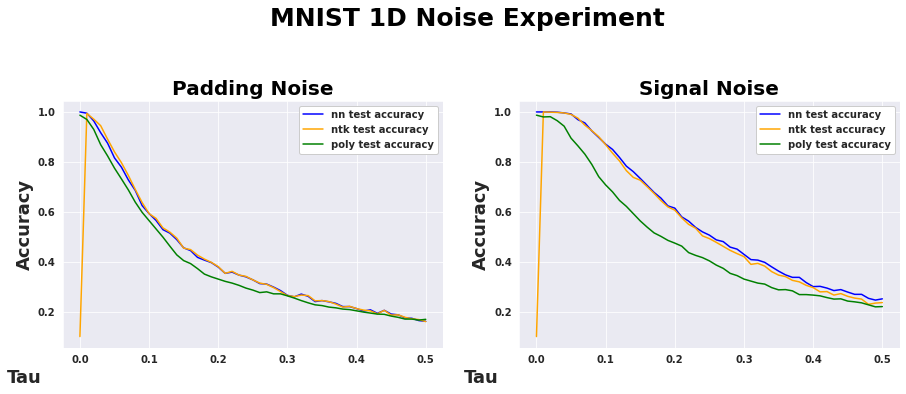

In [ ]:
plt_noise_experiment(
    log_nn_test_acc,
    log_ntk_test_acc,
    log_krr_test_acc,
    tau_1D,
)

In [ ]:
(
    log_krr_train_acc,
    log_krr_test_acc,
    log_ntk_train_acc,
    log_ntk_test_acc,
    log_nn_train_acc,
    log_nn_test_acc,
) = run_noise_experiments_1D(noisy_MNIST_1D_freq,)

Padding Noise | Tau 0.00 | KRR train acc 1.000 | KRR test acc 1.000 | NTK train acc 1.00 | NTK test acc 0.09 | NN train acc 1.00 | NN test acc 1.00
Padding Noise | Tau 0.25 | KRR train acc 1.000 | KRR test acc 0.985 | NTK train acc 1.00 | NTK test acc 1.00 | NN train acc 1.00 | NN test acc 1.00
Padding Noise | Tau 0.50 | KRR train acc 1.000 | KRR test acc 0.869 | NTK train acc 1.00 | NTK test acc 0.98 | NN train acc 1.00 | NN test acc 0.98
Padding Noise | Tau 0.75 | KRR train acc 1.000 | KRR test acc 0.662 | NTK train acc 1.00 | NTK test acc 0.91 | NN train acc 1.00 | NN test acc 0.91
Padding Noise | Tau 1.00 | KRR train acc 1.000 | KRR test acc 0.512 | NTK train acc 1.00 | NTK test acc 0.82 | NN train acc 1.00 | NN test acc 0.81
Padding Noise | Tau 1.25 | KRR train acc 1.000 | KRR test acc 0.400 | NTK train acc 1.00 | NTK test acc 0.72 | NN train acc 1.00 | NN test acc 0.72
Padding Noise | Tau 1.50 | KRR train acc 1.000 | KRR test acc 0.319 | NTK train acc 1.00 | NTK test acc 0.62 | N

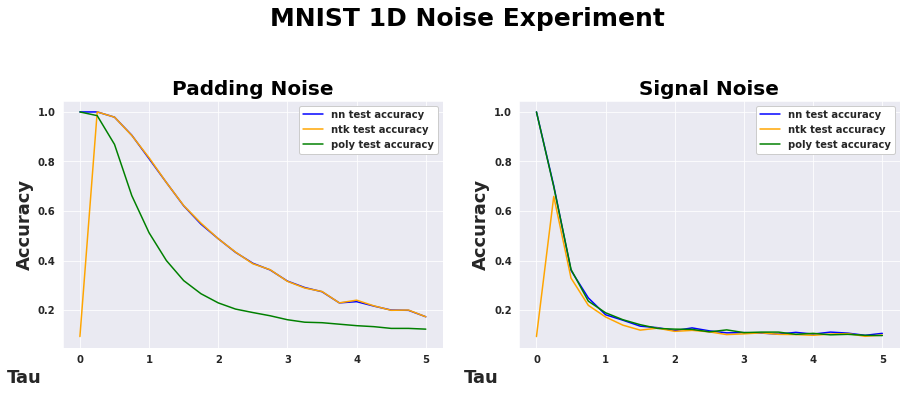

In [ ]:
plt_noise_experiment(
    log_nn_test_acc,
    log_ntk_test_acc,
    log_krr_test_acc,
    tau_1D_freq,
)

We can see that there is only a small difference in performance between the neural network and its neural tangent kernel. This is line with the [results of Arora et. al.](https://arxiv.org/abs/1910.01663), that neural tangent kernels are competitive in the small data regime. 

#### Define noise experiment for MNIST 2D

In [ ]:
@ignore_warnings(category=ConvergenceWarning)
def run_noise_experiments_2D(
    noisy_data: List[Dict], key: KeyArray = random.PRNGKey(1789),
) -> Union[List, List, List, List]:
    """
    Runs experiments comparing the performance of mlps and kernel methods 
    on MNIST training data injected with additive gaussian noise
    on the specified frequency modes of a discrete cosine transform.

    Args:
       noisy_data:
        A list containing MNIST datasets with various noisy levels injected.
      key:
        The random state for the experiments to be run in. 
        The state should be fixed for experiments to guarantee 
        consistency of the experiments. 

    Returns:
      List representing the logs of the accuracy of support vector classfication and
      trained neural networks.
    """

    learning_rate = 1e-3
    epochs = 20

    (
        log_svc_train_acc,
        log_svc_test_acc,
        log_nn_train_acc,
        log_nn_test_acc,
    ) = (
        [],
        [],
        [],
        [],
    )

    for data in noisy_data:


        freq = data["frequency"]
        tau = data["tau"]

        one_hot = jit(vmap(lambda x: jax.nn.one_hot(x, 10)))
        train_one_hot = one_hot(data["train_targets"])
        test_one_hot = one_hot(data["test_targets"])

        params, forward, kernel = two_layer_nn(batch_size=data['batch_size'], in_width=784)

        # Train neural network on noisy data
        (
            log_train_loss,
            log_test_loss,
            log_train_acc,
            log_test_acc,
            params,
        ) = training_loop(
            data,
            epochs,
            params,
            forward,
            initial_learning_rate=learning_rate,
            verbose=False,
        )

        clf = SVC(max_iter=100).fit(data["train_data"], data["train_targets"])
        svc_train_acc = clf.score(data["train_data"], data["train_targets"])
        svc_test_acc = clf.score(data["test_data"], data["test_targets"])

        nn_train_acc = accuracy(
            forward(params, data["train_data"]), data["train_targets"]
        )
        nn_test_acc = accuracy(
            forward(params, data["test_data"]), data["test_targets"]
        )

        log_svc_train_acc.append(svc_train_acc)
        log_svc_test_acc.append(svc_test_acc)

        log_nn_train_acc.append(nn_train_acc)
        log_nn_test_acc.append(nn_test_acc)

        print(
            "{} | Tau {:0.2f} | NN train acc {:0.4f} | "
            "NN test acc {:0.4f} | Linear train acc {:0.4f} | Linear test acc {:0.4f}".format(
                freq,
                tau,
                nn_train_acc,
                nn_test_acc,
                svc_train_acc,
                svc_test_acc,
            )
        )

    return (
        log_nn_train_acc,
        log_nn_test_acc,
        log_svc_train_acc,
        log_svc_test_acc,
    )

#### Run MNIST 2D experiment

In [ ]:
(
    log_nn_train_acc,
    log_nn_test_acc,
    log_svc_train_acc,
    log_svc_test_acc,
) = run_noise_experiments_2D(noisy_MNIST_2D,)

LF | Tau 0.00 | NN train acc 0.9940 | NN test acc 0.9876 | RBF SVC train acc 0.9727 | RBF SVC test acc 0.9583
LF | Tau 2.00 | NN train acc 1.0000 | NN test acc 0.8909 | RBF SVC train acc 0.6843 | RBF SVC test acc 0.6650
LF | Tau 4.00 | NN train acc 1.0000 | NN test acc 0.5903 | RBF SVC train acc 0.4009 | RBF SVC test acc 0.3859
LF | Tau 6.00 | NN train acc 1.0000 | NN test acc 0.3699 | RBF SVC train acc 0.2693 | RBF SVC test acc 0.2503
LF | Tau 8.00 | NN train acc 1.0000 | NN test acc 0.2557 | RBF SVC train acc 0.2038 | RBF SVC test acc 0.1840
HF | Tau 0.00 | NN train acc 0.9940 | NN test acc 0.9882 | RBF SVC train acc 0.9727 | RBF SVC test acc 0.9583
HF | Tau 2.00 | NN train acc 1.0000 | NN test acc 0.9666 | RBF SVC train acc 0.8393 | RBF SVC test acc 0.8169
HF | Tau 4.00 | NN train acc 1.0000 | NN test acc 0.9441 | RBF SVC train acc 0.7232 | RBF SVC test acc 0.7069
HF | Tau 6.00 | NN train acc 1.0000 | NN test acc 0.9223 | RBF SVC train acc 0.6247 | RBF SVC test acc 0.6106
HF | Tau 8

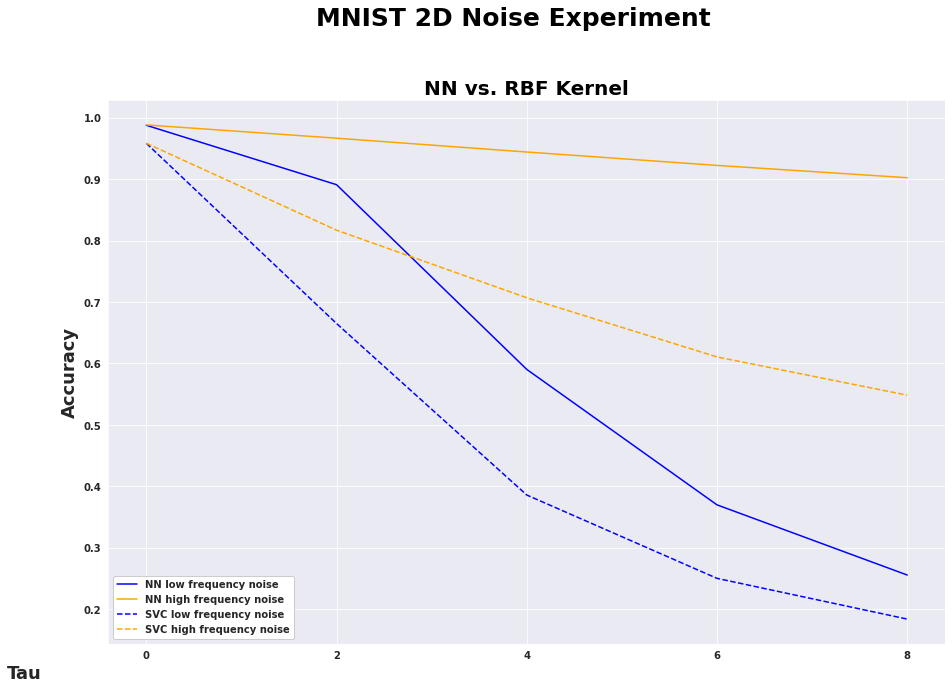

In [ ]:
plt_2D_noise_experiment(log_nn_test_acc, log_svc_test_acc, tau_2D)

## Summary

While there is cautious support for the conjecture by Ghorbani et. al., there remains a high degree of uncertainty.

Due the many engineering choices and unclear relation of the coded experiments to the mathematical models, conclusions are not straightforward. This is further complicated by missing sensivity analysis or uncertainty estimation.

Rigorous experimental design is needed to increase certainty and gain insights about the significance of our results.

## Synthetic data experiments <a name="synthetic"></a>

### Run synthetic data experiments

In [ ]:
def run_synth_experiments(
    experiment_key: KeyArray = random.PRNGKey(1453),
    kappas: Iterable = jnp.linspace(0, 0.9, 10),
) -> Union[List, List, List, List, List, List]:
    """
    Runs experiments comparing the performance of mlps and kernel methods 
    on synthetic training data generated according to a spiked covariates model.

    Args:
      key:
        The random state for the experiments to be run in. 
        The state should be fixed for experiments to guarantee 
        consistency of the experiments. 
      K:
        The kappa values to run the experiments for.

    Returns:
      List representing the logs of the mean squared errors
      of kernel ridge regression and fully trained neural networks during training.
    """

    # Hyperparameters
    learning_rate = 1e-3
    epochs = 100
    n = 10000
    batch_size = 100

    # Lists for logging
    (
        log_krr_train_error,
        log_krr_test_error,
        log_ntk_train_error,
        log_ntk_test_error,
        log_nn_train_error,
        log_nn_test_error,
    ) = (
        [],
        [],
        [],
        [],
        [],
        [],
    )

    for kappa in kappas:
        # Instatiate the network during each run to reset paramaters
        params, forward, kernel = two_layer_nn(
            batch_size=batch_size, in_width=1024, out_width=1
        )

        # Generate and prepare synthetic data for experiment
        data = gen_synth(experiment_key, kappa, n, batch_size)

        # Train neural network on synthetic data
        (
            log_train_loss,
            log_test_loss,
            log_train_acc,
            log_test_acc,
            params,
        ) = training_loop(
            data,
            epochs,
            params,
            forward=forward,
            initial_learning_rate=learning_rate,
            verbose=False,
        )

        # Perform kernel ridge regression on synthetic data
        yhat_train, yhat_test = krr(
            data["train_data"],
            data["test_data"],
            data["train_targets"],
            d=2,
            lambda_=synth_lambda,
            params=synth_params,
            kernel="polynomial",
        )

        yhat_train_ntk, yhat_test_ntk = ntk_fn(
            forward, kernel, params, data, learning_rate,
        )

        # Log errors
        krr_train_error = loss(yhat_train, data["train_targets"])
        krr_test_error = loss(yhat_test, data["test_targets"])
        ntk_train_error = loss(yhat_train_ntk, data["train_targets"])
        ntk_test_error = loss(yhat_test_ntk, data["test_targets"])
        nn_train_error = log_train_loss[-1]
        nn_test_error = log_test_loss[-1]

        log_krr_train_error.append(krr_train_error)
        log_krr_test_error.append(krr_test_error)
        log_ntk_train_error.append(ntk_train_error)
        log_ntk_test_error.append(ntk_test_error)
        log_nn_train_error.append(nn_train_error)
        log_nn_test_error.append(nn_test_error)

        print(
            "kappa {:0.1f} | KRR train loss"
            " {:0.4e} | KRR test loss {:0.4e} | NTK train loss"
            " {:0.4e} | NTK test loss {:0.4e} | NN train loss {:0.4e} | "
            "NN test loss {:0.4e}".format(
                kappa,
                krr_train_error,
                krr_test_error,
                ntk_train_error,
                ntk_test_error,
                nn_train_error,
                nn_test_error,
            )
        )

    return (
        log_krr_train_error,
        log_krr_test_error,
        log_ntk_train_error,
        log_ntk_test_error,
        log_nn_train_error,
        log_nn_test_error,
    )

In [ ]:
key, subkey = random.split(key)
(   
    log_krr_train_error,
    log_krr_test_error,
    log_ntk_train_error,
    log_ntk_test_error,
    log_nn_train_error,
    log_nn_test_error,
) = run_synth_experiments(subkey)

In [ ]:
plt_synth_experiment(
    log_nn_test_error,
    log_ntk_test_error,
    log_krr_test_error,
)